In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# We use Python's `functools.partial` to create a new function based on `fast_system` 
# with "eps" set to zero.
from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff
#from scipy.integrate import solve_ivp


# Define the ODE systems
def fast_system(y, t, eps):
    x, y = y
    dxdt = eps * y
    dydt = x - y
    return [dxdt, dydt]


fast_subsystem = partial(fast_system, eps=0)

# Define the Jacobian function
def jacobian(func, y):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        epsilon = 1e-6  
        y_perturbed = np.array(y.copy(), dtype=float)  
        y_perturbed[i] += epsilon
        dy = np.array(func(y_perturbed, 0)) - np.array(func(y, 0))
        J[:, i] = dy / epsilon
    return J

# Find equilibrium points of fast_subsystem numerically
#equilibrium_points = [np.zeros(len(fast_system([0, 0], 0)))] # [np.zeros(len(y))]
equilibrium_points = [np.zeros(len(fast_subsystem([0, 0], 0)))]

# Compute Jacobian matrix at each equilibrium point
for eq_point in equilibrium_points:
    J_eq = jacobian(fast_subsystem, eq_point)
    eigenvalues, eigenvectors = np.linalg.eig(J_eq)
    print("Jacobian Matrix:")
    print(J_eq)
    print("Eigenvalues:")
    print(eigenvalues)
    print("Eigenvectors:")
    print(eigenvectors)
    print("Eigenvectors (shape):", eigenvectors.shape)
    v1, v2 = eigenvectors[:, 0]
    v1 = torch.tensor(v1, dtype=torch.float32)
    v2 = torch.tensor(v2, dtype=torch.float32)
    # Normalize the given direction vector
    magnitude_target = torch.sqrt(v1**2 + v2**2)
    v1_normalized = v1 / magnitude_target
    v2_normalized = v2 / magnitude_target
    print()
    # Check if any eigenvalue has a pure imaginary part
    if any(np.imag(eigenvalues) != 0):
        print("The system is NOT NORMALLY HYPERBOLIC. Stopping...")
        break
    else:
        print("The system is NORMALLY HYPERBOLIC. Proceeding...\n")

def slow_system(y, tau, eps):
    x, y = y
    dxdtau = y
    dydtau = (x-y)/eps
    return [dxdtau, dydtau]


eps = 0.001


x_init, y_init = 1 + 0 * eps, 2.0 - 0 * eps  
print('The initial points of the BVP:', f"x_init = {x_init}, y_init = {y_init}")

t_end = 70
t  =  np.linspace(0, t_end, 1000)

T_slow_end = 0.70
tau = np.linspace(0, T_slow_end, 1000)


x_end, y_end = 2.0 - 0 * eps, 2.0 + 0 * eps
print('The ending points of the BVP:', f"x_end = {x_end}, y_end = {y_end}")


t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)

def Exact_solution(t, eps, x_init, y_init):
    sqrt_term = np.sqrt(1 + 4 * eps)
    r1 = (-1 + sqrt_term) / (2 * eps)
    r2 = (-1 - sqrt_term) / (2 * eps)
    
    C1 = (y_init - r2 * x_init) / (r1 - r2)
    C2 = (r1 * x_init - y_init) / (r1 - r2)
    

    x_exact = C1 * np.exp(r1 * t) + C2 * np.exp(r2 * t)
    y_exact = C1 * r1 * np.exp(r1 * t) + C2 * r2 * np.exp(r2 * t) 

    return x_exact, y_exact

x_exact, y_exact = Exact_solution(0.01 *t, eps, x_init, y_init)




t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)

x_exact_tensor = torch.tensor(x_exact.reshape(-1, 1), dtype=torch.float64)
y_exact_tensor = torch.tensor(y_exact.reshape(-1, 1), dtype=torch.float64)

def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 5

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

    
phys_weight = 10

def loss_func_fast(model, t_tensor, x_init, y_init,\
                                   xf_end, yf_end, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast = pred_fast[:, 0].unsqueeze(1),\
                               pred_fast[:, 1].unsqueeze(1)
                                           

           
    ones = torch.ones_like(x_pred_fast, requires_grad=True)  
    dx_dt = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast = dx_dt - eps * y_pred_fast
    residual2_fast = dy_dt - x_pred_fast + y_pred_fast
    
    
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init) 
    physics_loss_fast = torch.mean(residual1_fast**2+ residual2_fast**2 )

    boundary_loss_fast = torch.square(x_pred_fast[-1] - xf_end) +\
                         torch.square(y_pred_fast[-1] - yf_end) 
        
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast +\
                      boundary_loss_fast 

    return total_loss_fast


def loss_func_slow(model, tau_tensor, xs_init, ys_init, x_end, y_end, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)   
    
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_slow = dx_dtau  - y_pred_slow 
    residual2_slow = eps * dy_dtau - x_pred_slow + y_pred_slow
    init_loss_slow = torch.square(x_pred_slow[0] - xs_init) +\
                     torch.square(y_pred_slow[0] - ys_init) 
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2)
    
    boundary_loss_slow = torch.square(x_pred_slow[-1] - x_end) +\
                         torch.square(y_pred_slow[-1] - y_end)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow


def total_loss_func(model_fast, model_slow,\
                    t_tensor, tau_tensor,\
                    x_init, y_init, xf_end, yf_end,\
                    xs_init, ys_init,\
                    x_end, y_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init,\
                                                   xf_end, yf_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               xs_init, ys_init, x_end, y_end, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow 
    
    return total_loss




Jacobian Matrix:
[[ 0.  0.]
 [ 1. -1.]]
Eigenvalues:
[-1.  0.]
Eigenvectors:
[[0.         0.70710678]
 [1.         0.70710678]]
Eigenvectors (shape): (2, 2)

The system is NORMALLY HYPERBOLIC. Proceeding...

The initial points of the BVP: x_init = 1.0, y_init = 2.0
The ending points of the BVP: x_end = 2.0, y_end = 2.0


Epoch 0, Total Loss: 13.485579072664965
Epoch 1000, Total Loss: 0.03880022445465188
Epoch 2000, Total Loss: 0.004266496531432272
Epoch 3000, Total Loss: 0.0019476405045503577
Epoch 4000, Total Loss: 0.001174509141146987
Epoch 5000, Total Loss: 0.000496022512360027
Epoch 6000, Total Loss: 0.00015797075104850993
Epoch 7000, Total Loss: 9.34762208964072e-05
Epoch 8000, Total Loss: 6.981312712294697e-05
Epoch 9000, Total Loss: 5.490937120155991e-05
Epoch 10000, Total Loss: 4.554190759542979e-05
Epoch 11000, Total Loss: 3.942329435571438e-05
Epoch 12000, Total Loss: 3.641813878914417e-05
Epoch 13000, Total Loss: 3.2339950753675444e-05
Epoch 14000, Total Loss: 3.0087575188896087e-05
Epoch 15000, Total Loss: 2.831236005227274e-05
Epoch 16000, Total Loss: 2.688248670991674e-05
Epoch 17000, Total Loss: 2.5962228849359564e-05
Epoch 18000, Total Loss: 2.471663478973135e-05
Epoch 19000, Total Loss: 2.3859838877023425e-05
Epoch 20000, Total Loss: 2.3104650184045168e-05
Epoch 21000, Total Loss: 2.24

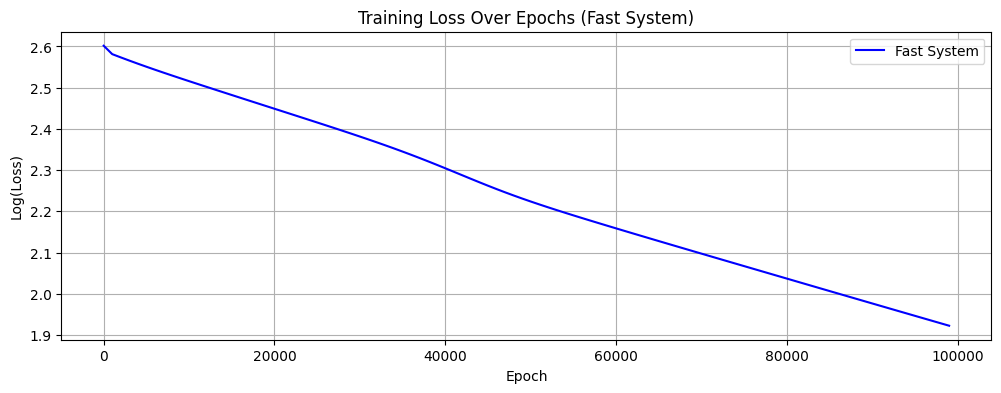

In [9]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)
    
    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 100000


    xf_end, yf_end = np.random.random(), np.random.random()

    xs_init, ys_init = np.random.random(), np.random.random()
    

    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow,\
                                     t_tensor, tau_tensor,\
                                     x_init, y_init, xf_end, yf_end,\
                                     xs_init, ys_init,\
                                     x_end, y_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            x_pred_fast, y_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_slow, y_pred_slow = model_slow(tau_tensor).numpy().T
            
            xf_end,  yf_end = x_pred_slow[0], y_pred_slow[0]
            xs_init, ys_init = x_pred_fast[-1], y_pred_fast[-1]
           
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
            
        loss_values.append(loss_total.item())
        
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_slow.eval()
    with torch.no_grad():
        # Predictions for fast system
        x_pred_fast, y_pred_fast = model_fast(t_tensor).numpy().T
        # Predictions for slow system
        x_pred_slow, y_pred_slow = model_slow(tau_tensor).numpy().T





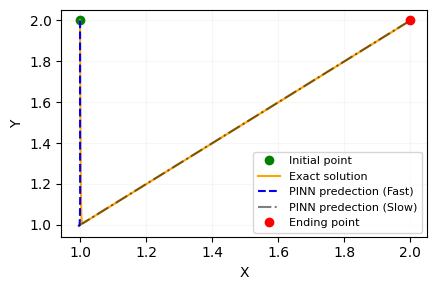

(990,)
(1000,)
(1000,)


In [24]:
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_subplot(111)

ax.plot(x_init, y_init, 'go', label='Initial point')

ax.plot(x_exact[:-10], y_exact[:-10], '-', color='orange', label='Exact solution')


ax.plot(x_pred_fast, y_pred_fast, 'b--', label='PINN predection (Fast)')

ax.plot(x_pred_slow , y_pred_slow , 'k-.', label='PINN predection (Slow)', alpha=0.5)
ax.plot(x_end, y_end, 'ro', label='Ending point')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
#ax.invert_yaxis()
plt.grid(True, alpha=0.1)

ax.legend(prop={'size': 8}, bbox_to_anchor=(0.51, 0.4))

plt.tight_layout()
plt.show()

shape_x_exact = x_exact[:-10].shape
print(shape_x_exact)
shape_x_pred_fast = x_pred_fast.shape
print(shape_x_pred_fast)
shape_x_pred_slow = x_pred_slow.shape
print(shape_x_pred_slow)

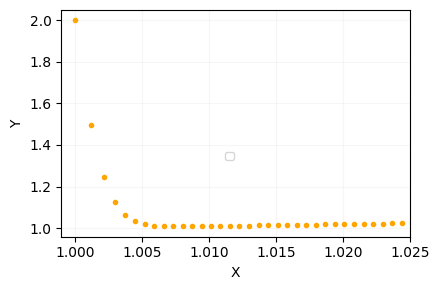

(990,)
(1000,)
(1000,)


In [33]:
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_subplot(111)


ax.plot(x_exact[:-10], y_exact[:-10], '.', color='orange')



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
#ax.invert_yaxis()
plt.grid(True, alpha=0.1)

ax.legend(prop={'size': 8}, bbox_to_anchor=(0.51, 0.4))
ax.set_xlim(0.999, 1.025)
plt.tight_layout()
plt.show()

shape_x_exact = x_exact[:-10].shape
print(shape_x_exact)
shape_x_pred_fast = x_pred_fast.shape
print(shape_x_pred_fast)
shape_x_pred_slow = x_pred_slow.shape
print(shape_x_pred_slow)

In [17]:
print(y_pred_slow[0])
print(y_exact[0])
split_index = np.argmin(np.abs(y_exact[:-10] - y_pred_slow[0]))

print()
print(split_index)
print(x_exact[:-10][split_index])


x_exact_fast = x_exact[:-10][:split_index]
y_exact_fast = y_exact[:-10][:split_index]
x_exact_slow = x_exact[:-10][split_index:]
y_exact_slow = y_exact[:-10][split_index:]

0.9943039758311555
2.0

10
1.0080296925990735


10


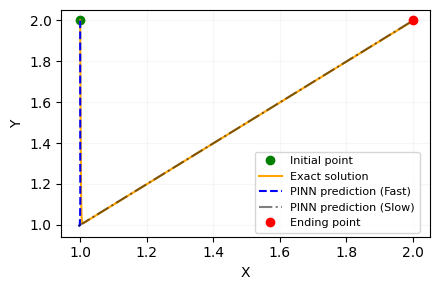

(990,)
(1000,)
(1000,)


In [43]:

print(split_index)

x_exact_fast = x_exact[:-10][:split_index]
y_exact_fast = y_exact[:-10][:split_index]
x_exact_slow = x_exact[:-10][split_index:]
y_exact_slow = y_exact[:-10][split_index:]

positions_fast = np.linspace(0, 1, len(x_exact_fast))

positions_slow = np.linspace(0, 1, len(x_exact_slow))

######################################################

closest_xfast_indices = []
for x_f_exact_point in x_exact_fast:
    closest_xf_index = np.argmin(np.abs(x_pred_fast - x_f_exact_point))
    closest_xfast_indices.append(closest_xf_index)

xf_pred_closest = x_pred_fast[closest_xfast_indices]
error_fast_x = (x_exact_fast - xf_pred_closest) ** 2

##############

closest_yfast_indices = []
for y_f_exact_point in y_exact_fast:
    closest_yf_index = np.argmin(np.abs(y_pred_fast - y_f_exact_point))
    closest_yfast_indices.append(closest_yf_index)

yf_pred_closest = y_pred_fast[closest_yfast_indices]
error_fast_y = (y_exact_fast - yf_pred_closest) ** 2

######################################################

closest_xslow_indices = []
for x_s_exact_point in x_exact_slow:
    closest_xs_index = np.argmin(np.abs(x_pred_slow - x_s_exact_point))
    closest_xslow_indices.append(closest_xs_index)

xs_pred_closest = x_pred_slow[closest_xslow_indices]
error_slow_x = (x_exact_slow - xs_pred_closest) ** 2

##############

closest_yslow_indices = []
for y_s_exact_point in y_exact_slow:
    closest_ys_index = np.argmin(np.abs(y_pred_slow - y_s_exact_point))
    closest_yslow_indices.append(closest_ys_index)

ys_pred_closest = y_pred_slow[closest_yslow_indices]
error_slow_y = (y_exact_slow - ys_pred_closest) ** 2





max_error_fast_x = np.max(error_fast_x)
max_error_fast_y = np.max(error_fast_y)
max_error_slow_x = np.max(error_slow_x)
max_error_slow_y = np.max(error_slow_y)


# Plotting for visualization
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3))

# Plot the solutions
axs.plot(x_init, y_init, 'go', label='Initial point')
axs.plot(x_exact[:-10], y_exact[:-10], '-', color='orange', label='Exact solution')
axs.plot(x_pred_fast, y_pred_fast, 'b--', label='PINN prediction (Fast)')
axs.plot(x_pred_slow, y_pred_slow, 'k-.', label='PINN prediction (Slow)', alpha=0.5)
axs.plot(x_end, y_end, 'ro', label='Ending point')

axs.set_xlabel('X')
axs.set_ylabel('Y')
axs.legend()
axs.grid(True, alpha=0.1)
axs.legend(prop={'size': 8}, bbox_to_anchor=(0.51, 0.4))

plt.tight_layout()
plt.show()

shape_x_exact = x_exact[:-10].shape
print(shape_x_exact)
shape_x_pred_fast = x_pred_fast.shape
print(shape_x_pred_fast)
shape_x_pred_slow = x_pred_slow.shape
print(shape_x_pred_slow)


In [45]:
print(len(positions_fast))
print(len(error_fast_x))
print(len(error_fast_y))

print()

print(len(positions_slow))
print(len(error_slow_x))
print(len(error_slow_y))

10
10
10

980
980
980


Maximum error in X (Fast): 4.7544868291643024e-05
Maximum error in Y (Fast): 6.329575146519618e-06
Maximum error in X (Slow): 1.9182149262039996e-07
Maximum error in Y (Slow): 1.867156310196402e-07


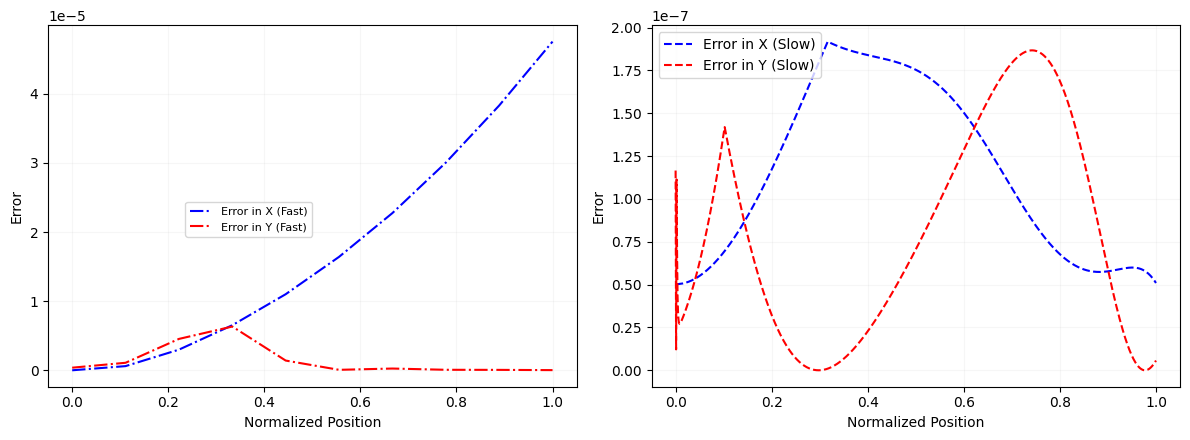

In [60]:
# Print maximum errors
print(f"Maximum error in X (Fast): {max_error_fast_x}")
print(f"Maximum error in Y (Fast): {max_error_fast_y}")
print(f"Maximum error in X (Slow): {max_error_slow_x}")
print(f"Maximum error in Y (Slow): {max_error_slow_y}")


# Plotting for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot the solutions
axs[0].plot(positions_fast, error_fast_x, '-.', color ='blue', label='Error in X (Fast)')
axs[0].plot(positions_fast, error_fast_y, 'r-.', label='Error in Y (Fast)')


axs[0].set_xlabel('Normalized Position')
axs[0].set_ylabel('Error')
axs[0].legend()
axs[0].grid(True, alpha=0.1)
axs[0].legend(prop={'size': 8}, bbox_to_anchor=(0.51, 0.4))

axs[1].plot(positions_slow, error_slow_x, '--', color ='blue', label='Error in X (Slow)')
axs[1].plot(positions_slow, error_slow_y, 'r--', label='Error in Y (Slow)')

axs[1].set_xlabel('Normalized Position')
axs[1].set_ylabel('Error')
axs[1].legend()
axs[1].grid(True, alpha=0.1)
axs[0].legend(prop={'size': 8}, bbox_to_anchor=(0.51, 0.4))
plt.tight_layout()
plt.show()


Maximum error in X (Fast): 4.7544868291643024e-05
Maximum error in Y (Fast): 6.329575146519618e-06
Maximum error in X (Slow): 1.9182149262039996e-07
Maximum error in Y (Slow): 1.867156310196402e-07


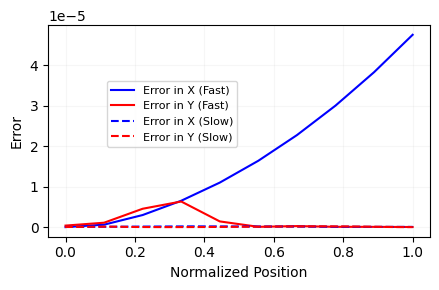

In [59]:
# Print maximum errors
print(f"Maximum error in X (Fast): {max_error_fast_x}")
print(f"Maximum error in Y (Fast): {max_error_fast_y}")
print(f"Maximum error in X (Slow): {max_error_slow_x}")
print(f"Maximum error in Y (Slow): {max_error_slow_y}")


# Plotting for visualization
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3))

# Plot the solutions
axs.plot(positions_fast, error_fast_x, '-', color ='blue', label='Error in X (Fast)')
axs.plot(positions_fast, error_fast_y, 'r-', label='Error in Y (Fast)')
axs.plot(positions_slow, error_slow_x, '--', color ='blue', label='Error in X (Slow)')
axs.plot(positions_slow, error_slow_y, 'r--', label='Error in Y (Slow)')


axs.set_xlabel('Normalized Position')
axs.set_ylabel('Error')
axs.legend()
axs.grid(True, alpha=0.1)
axs.legend(prop={'size': 8}, bbox_to_anchor=(0.51, 0.4))


plt.tight_layout()
plt.show()


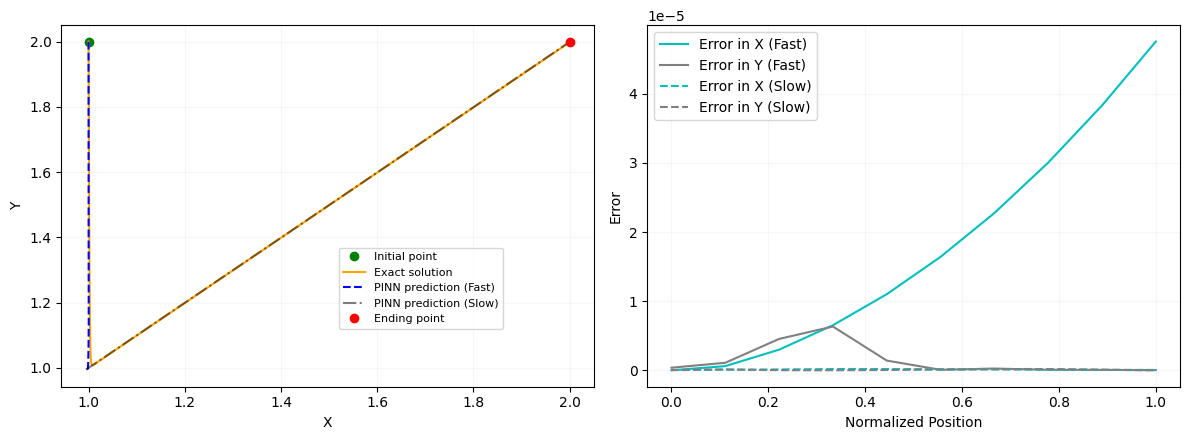

(690,)
(1000,)
(1000,)


In [72]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot the solutions
axs[0].plot(x_init, y_init, 'go', label='Initial point')
axs[0].plot(x_exact[:-10], y_exact[:-10], '-', color='orange', label='Exact solution')
axs[0].plot(x_pred_fast, y_pred_fast, 'b--', label='PINN prediction (Fast)')
axs[0].plot(x_pred_slow, y_pred_slow, 'k-.', label='PINN prediction (Slow)', alpha=0.5)
axs[0].plot(x_end, y_end, 'ro', label='Ending point')

axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].legend()
axs[0].grid(True, alpha=0.1)
axs[0].legend(prop={'size': 8}, bbox_to_anchor=(0.51, 0.4))

axs[1].plot(positions_fast, error_fast_x, '-',color='c', label='Error in X (Fast)')
axs[1].plot(positions_fast, error_fast_y, '-',color='grey', label='Error in Y (Fast)')
axs[1].plot(positions_slow, error_slow_x, '--',color='c', label='Error in X (Slow)')
axs[1].plot(positions_slow, error_slow_y, '--', color='grey', label='Error in Y (Slow)')

axs[1].set_xlabel('Normalized Position')
axs[1].set_ylabel('Error')
axs[1].legend()
axs[1].grid(True, alpha=0.1)

plt.tight_layout()
plt.show()

shape_x_exact = x_exact[:-310].shape
print(shape_x_exact)
shape_x_pred_fast = x_pred_fast.shape
print(shape_x_pred_fast)
shape_x_pred_slow = x_pred_slow.shape
print(shape_x_pred_slow)

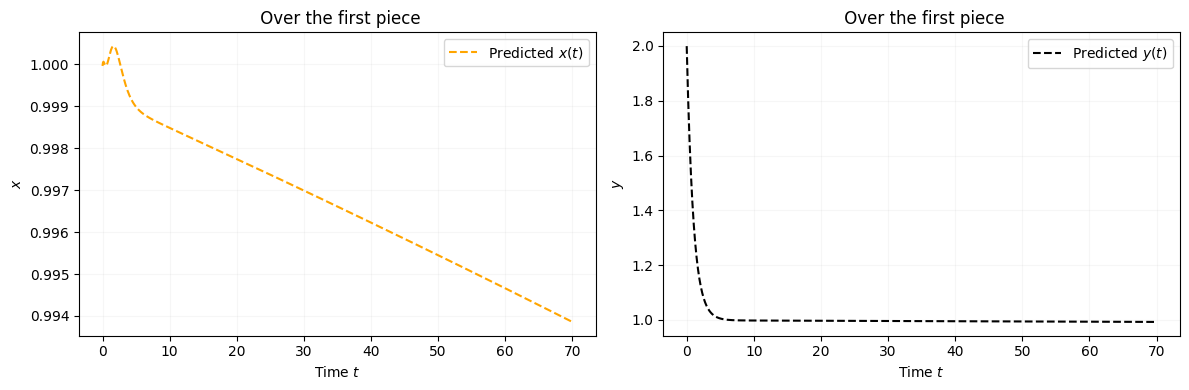

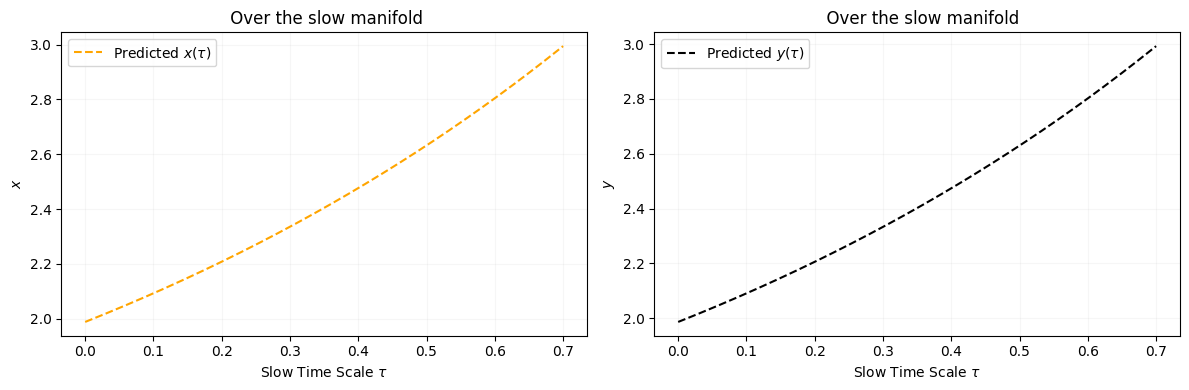

In [13]:
#########1st piece
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
#plt.plot(t, x_exact, 'b-', label='Exact $x(t)$')
plt.plot(t, x_pred_fast, '--', color='orange', label='Predicted $x(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$x$')
plt.title(' Over the first piece')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 2, 2)
#plt.plot(t, y_exact_fast, 'b-', label='Exact $y(t)$')
plt.plot(t, y_pred_fast, 'k--', label='Predicted $y(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$y$')
plt.title(' Over the first piece')
plt.grid(True, alpha=0.1)
plt.legend()


# Adjust y-axis tick label formatting
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.offsetText.set_fontsize(10)  # Adjust font size as needed
ax.tick_params(axis='y', pad=5)  # Adjust the padding as needed


plt.tight_layout()
plt.show()

########2nd piece
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(tau, x_pred_slow + x_pred_fast[-1], '--', color='orange', label='Predicted $x(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$x$')
plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 2, 2)
#plt.plot(tau, y_exact_slow + y_exact_fast[-1], 'b-', label='Exact $y(t)$')
plt.plot(tau, y_pred_slow + y_pred_fast[-1], 'k--', label='Predicted $y(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$y$')
plt.title('  Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

# Adjust y-axis tick label formatting
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.offsetText.set_fontsize(10)  # Adjust font size as needed
ax.tick_params(axis='y', pad=5)  # Adjust the padding as needed


plt.tight_layout()
plt.show()


